In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import joblib

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Prepare

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
print(f'{len(covs)} covariates')

# data
all = pd.read_parquet(f'{folder_path}/data/003_data_overlaid.organized.pq')

# set up
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

all[tgt] = np.log1p(all[prop])

67 covariates


# Initialize Isolation tree

In [4]:
from trees_rf import cast_tree_rf
isof = IsolationForest(random_state=42) 

n_splits = 5 
random_state = 42

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize columns to store results
all['iso_class'] = np.nan
all['iso_score'] = np.nan
all['ocd_pred'] = np.nan
all['ocd_pred_log1p'] = np.nan

# Cross-validation
for train_index, val_index in kf.split(all):
    train_fold = all.iloc[train_index]
    val_fold = all.iloc[val_index]
    
    # Train IsolationForest on train fold
    isof = IsolationForest(random_state=random_state)
    isof.fit(train_fold[covs])
    model.fit(train_fold[covs],train_fold[tgt])
    
    # Predict and score on the validation fold
    iso_class = isof.predict(val_fold[covs])
    iso_score = isof.decision_function(val_fold[covs])
    
    # generate corresponding predictions for examination
    model = cast_tree_rf(model)
    tree_predictions = model.predict(val_fold[covs])
    y_pred= np.mean(tree_predictions, axis=0)
    all.loc[val_fold.index, 'ocd_pred'] = y_pred
    all.loc[val_fold.index, 'ocd_pred_log'] = np.expm1(y_pred)
    
    # generate corresponding piw for examination
    tree_predictions = np.expm1(tree_predictions)
    quantiles_95 = [0.025, 0.975]
    y_95 = np.percentile(tree_predictions, [q * 100 for q in quantiles_95], axis=0)
    piw = y_95[1,:] - y_95[0,:]
    all.loc[val_fold.index, 'piw'] = piw

    # Assign values back to the validation fold in the original DataFrame
    all.loc[val_fold.index, 'iso_class'] = iso_class
    all.loc[val_fold.index, 'iso_score'] = iso_score
    # all.loc[val_fold.index, 'ocd_pred'] = np.expm1(pred)
    # all.loc[val_fold.index, 'ocd_pred_log'] = pred

In [5]:
all

,time,lat,lon,hzn_dep,id,ref,nuts0,lc_survey,ocd,evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY0228_eu_epsg.3035_v20231127,...,pet.penman.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531,bioclim.var_chelsa.bio18_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822,tile_id,ocd_log1p,iso_class,iso_score,ocd_pred,ocd_pred_log1p,ocd_pred_log,piw
0,2002,38.386915,-1.512766,5.0,2537,ParcelasINES,ES,cropland,38.292640,150.0,...,3831.0,408.0,710,3.671037,1.0,0.055814,2.709809,NaN,14.026402,25.311925
1,2002,38.301725,-1.971962,5.0,2560,ParcelasINES,ES,grassland,30.108502,145.0,...,3042.0,679.0,710,3.437481,1.0,0.097166,3.116457,NaN,21.566275,35.643890
2,2002,38.300667,-1.913662,5.0,2561,ParcelasINES,ES,cropland,16.151392,145.0,...,4143.0,643.0,710,2.842079,1.0,0.093628,2.633241,NaN,12.918810,31.663334
3,2002,38.318951,-1.589435,5.0,2919,ParcelasINES,ES,woodland,14.600485,149.0,...,4794.0,435.0,710,2.747302,1.0,0.045125,2.425137,NaN,10.303779,32.074214
5,2002,38.017793,-0.949626,5.0,3194,ParcelasINES,ES,grassland,19.365596,139.0,...,4339.0,240.0,709,3.013847,1.0,0.061110,2.800157,NaN,15.447222,100.353670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46838,2020,37.660679,-1.015664,20.0,841,ParcelasCOS,ES,cropland,9.692317,140.0,...,5022.0,426.0,709,2.369525,1.0,0.046270,2.485057,NaN,11.001808,36.647783
46839,2020,37.405054,-2.378570,20.0,856,ParcelasCOS,ES,grassland,7.631770,141.0,...,5273.0,311.0,672,2.155450,1.0,0.041622,2.615923,NaN,12.679839,54.179717
46840,2020,37.402885,-2.039608,20.0,857,ParcelasCOS,ES,cropland,5.058466,151.0,...,4787.0,234.0,709,1.801457,1.0,0.018789,2.282768,NaN,8.803778,46.455433
46841,2020,37.132557,-2.043137,20.0,872,ParcelasCOS,ES,grassland,18.345600,146.0,...,5675.0,172.0,709,2.962465,1.0,0.008034,2.546517,NaN,11.762573,23.409777


# transform iso scores to probability

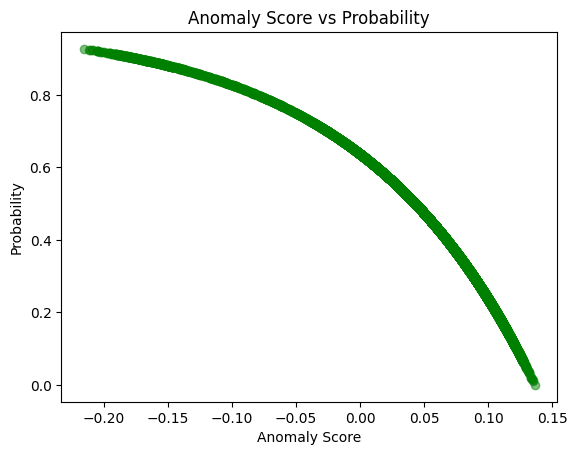

In [7]:
# Invert scores to match R's convention (higher = more anomalous)
iso_score_reverted = -1 * all['iso_score']

# Scale scores to [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(iso_score_reverted.values.reshape(-1, 1)).flatten()

# Calculate probabilities
average_decision_score = np.mean(scaled_scores)
prob = 1 - np.exp(-scaled_scores / (average_decision_score * 2))

# Assign probabilities back to the DataFrame
all['prob'] = prob

# Plot the anomaly scores vs probabilities
plt.scatter(all['iso_score'], prob, alpha=0.5, color="green")
plt.title("Anomaly Score vs Probability")
plt.xlabel("Anomaly Score")
plt.ylabel("Probability")
plt.show()

In [8]:
all['ae'] = all['ocd_pred'] - all['ocd']
epsilon = 0.1 #1e-2
adjusted_ocd = all['ocd'].replace(0, epsilon)
all['mape'] = abs(all['ocd_pred'] - all['ocd']) / adjusted_ocd

In [9]:
bins = [0, 20, 50, 100, 200]
labels = ['0-20', '20-50', '50-100', '100-200']
all['hzn_dep_bin'] = pd.cut(all['hzn_dep'], bins=bins, labels=labels, right=False)

grouped_stats = all.groupby(['lc_survey', 'hzn_dep_bin'])['mape'].describe()
grouped_stats

count      mean       std       min  \
lc_survey                hzn_dep_bin                                          
artificial land          0-20            25.0  0.828589  0.133542  0.246752   
bare land & lichens/moss 0-20           933.0  1.466048  3.264675  0.000000   
cropland                 0-20         13031.0  0.790655  0.956562  0.001779   
                         20-50         5017.0  0.745708  0.295173  0.001451   
                         50-100        4710.0  0.617266  0.666029  0.000331   
                         100-200        111.0  0.693444  0.281979  0.070060   
grassland                0-20          8316.0  0.841675  0.507842  0.003497   
                         20-50         1905.0  0.854352  1.879895  0.000526   
                         50-100        1660.0  0.736358  1.251535  0.000888   
                         100-200        135.0  1.062128  2.381389  0.019617   
shrubland                0-20           187.0  0.857478  0.104125  0.242489   
water areas & wetland    0-20             7.0  0.782045  0.301776  0.171316   
woodland                 0-20          9017.0  0.833941  0.402606  0.000888   
                         20-50          357.0  1.195653  2.188135  0.022780   
                         50-100          59.0  2.418508  2.527654  0.032136   

                                           25%       50%       75%        max  
lc_survey                hzn_dep_bin                                           
artificial land          0-20         0.820092  0.844123  0.878931   0.963777  
bare land & lichens/moss 0-20         0.000000  0.368789  0.868602  30.770161  
cropland                 0-20         0.714671  0.812592  0.867633  83.766209  
                         20-50        0.667776  0.798693  0.854661   9.643725  
                         50-100       0.366716  0.568405  0.735474  17.660658  
                         100-200      0.561926  0.753242  0.870511   1.681586  
grassland                0-20         0.788269  0.873531  0.917394  34.416095  
                         20-50        0.708382  0.821907  0.888085  79.411546  
                         50-100       0.446960  0.646303  0.818692  26.102406  
                         100-200      0.759610  0.902996  0.919967  28.123517  
shrubland                0-20         0.822034  0.882982  0.929488   0.977693  
water areas & wetland    0-20         0.729379  0.939053  0.967305   0.970577  
woodland                 0-20         0.782793  0.867922  0.915860  22.395826  
                         20-50        0.705646  0.835229  0.898245  28.935317  
                         50-100       0.542945  1.227662  3.845012  10.507954

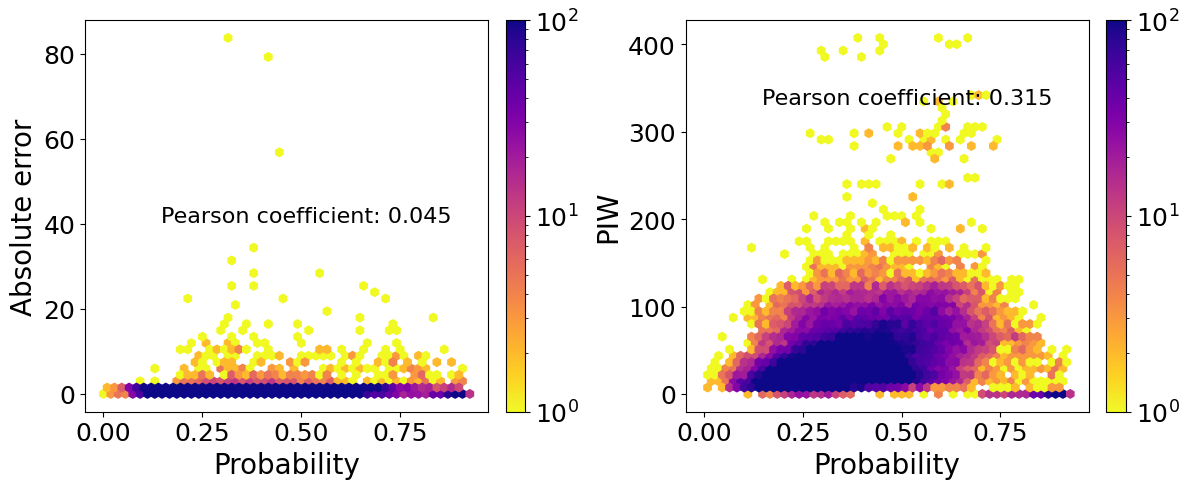

In [12]:
var = 'prob'
name = 'Probability'

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ccc_prob = calc_ccc(all[var], all[var])
co_prob = np.corrcoef(all[var], all['mape'])[0, 1]  
hb1 = axes[0].hexbin(all[var], all['mape'], gridsize=50, cmap='plasma_r', mincnt=1, vmax=100, bins='log')
axes[0].set_xlabel(name, fontsize=20)
axes[0].set_ylabel('Absolute error', fontsize=20)
# axes[0].set_ylim([0,25])
axes[0].tick_params(labelsize=18)
axes[0].text(0.55, 0.5, f"Pearson coefficient: {co_prob:.3f}", fontsize=16, transform=axes[0].transAxes, ha='center', va='center')
cbar1 = fig.colorbar(hb1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18)

# ccc_iso = calc_ccc(all['iso_score'], all[var])
co_iso = np.corrcoef(all[var], all['piw'])[0, 1]  
hb2 = axes[1].hexbin(all[var], all['piw'], gridsize=50, cmap='plasma_r', mincnt=1, vmax=100, bins='log')
axes[1].set_xlabel(name, fontsize=20)
axes[1].set_ylabel('PIW', fontsize=20)
axes[1].tick_params(labelsize=18)
axes[1].text(0.55, 0.8, f"Pearson coefficient: {co_iso:.3f}", fontsize=16, transform=axes[1].transAxes, ha='center', va='center')
cbar2 = fig.colorbar(hb2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18)  

plt.tight_layout()
plt.show()

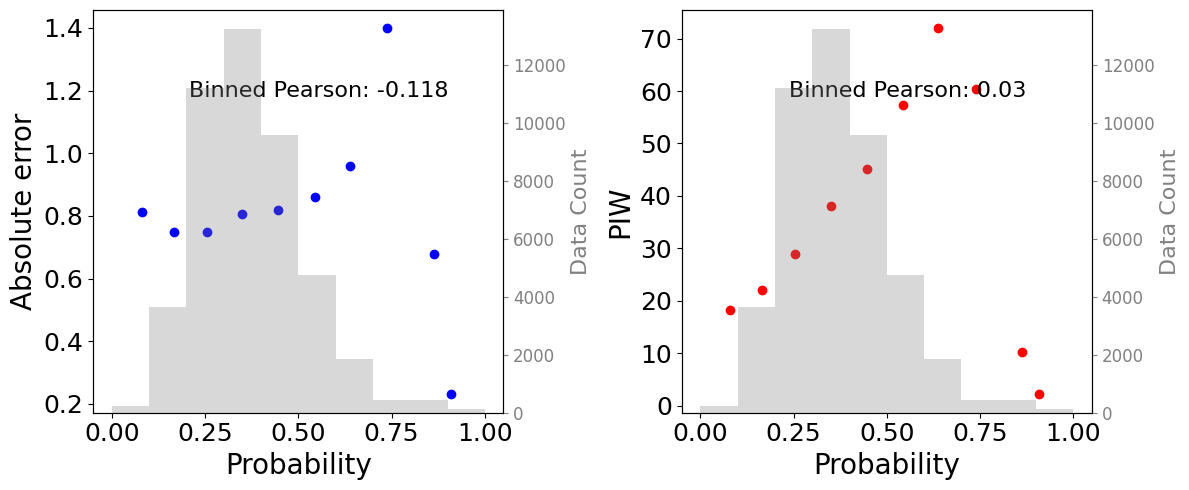

In [13]:

bin_width = 0.1

# Binning data on Probability
prob_bins = np.arange(all['prob'].min(), all['prob'].max() + bin_width, bin_width)
prob_bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2  # Calculate bin centers
prob_means = all.groupby(pd.cut(all['prob'], prob_bins))['prob'].mean()
ae_means_prob = all.groupby(pd.cut(all['prob'], prob_bins))['mape'].mean()
piw_means_prob = all.groupby(pd.cut(all['prob'], prob_bins))['piw'].mean()

valid_prob_mask = ~prob_means.isna() & ~ae_means_prob.isna()
prob_means = prob_means[valid_prob_mask]
ae_means_prob = ae_means_prob[valid_prob_mask]
piw_means_prob = piw_means_prob[valid_prob_mask]

co_ae = np.corrcoef(prob_means, ae_means_prob)[0, 1]
co_piw = np.corrcoef(prob_means, piw_means_prob)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1_bar = ax1.twinx()  

counts_prob = all.groupby(pd.cut(all['prob'], prob_bins))['prob'].count()
ax1_bar.bar(prob_bin_centers, counts_prob, width=bin_width, color='grey', alpha=0.3, label='Data Count')
ax1_bar.set_ylabel('Data Count', fontsize=16, color='grey')
ax1_bar.tick_params(axis='y', labelsize=12, colors='grey')

ax1.scatter(prob_means, ae_means_prob, color='blue', label='Binned Averages')
ax1.set_xlabel('Probability', fontsize=20)
ax1.set_ylabel('Absolute error', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.text(0.55, 0.8, f"Binned Pearson: {co_ae:.3f}", fontsize=16, transform=ax1.transAxes, ha='center', va='center')
# ax1.legend(fontsize=16)

ax2 = axes[1]
ax2_bar = ax2.twinx()  

ax2_bar.bar(prob_bin_centers, counts_prob, width=bin_width, color='grey', alpha=0.3, label='Data Count')
ax2_bar.set_ylabel('Data Count', fontsize=16, color='grey')
ax2_bar.tick_params(axis='y', labelsize=12, colors='grey')

# Scatter plot
ax2.scatter(prob_means, piw_means_prob, color='red', label='Binned Averages')
ax2.set_xlabel('Probability', fontsize=20)
ax2.set_ylabel('PIW', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.text(0.55, 0.8, f"Binned Pearson: {co_piw:.2f}", fontsize=16, transform=ax2.transAxes, ha='center', va='center')
# ax2.legend(fontsize=16)

plt.tight_layout()
plt.show()


# Observations on Extrapolation Probability and Error/PIW

A weak correlation is observed between extrapolation probability and absolute error or Prediction Interval Width (PIW), which aligns with findings reported by Hateffard et al. (2024) ([source](https://www.sciencedirect.com/science/article/pii/S0016706123004172)). Hateffard et al. (2024) also identified a similarly weak relationship between other extrapolation indicators, such as Area of Applicability (AOA), and error/PIW. 

This highlights the need for further investigation to explore these relationships in greater depth.


# production isolation tree model

In [21]:
all = pd.read_parquet(f'{folder_path}/data/003_data_overlaid.organized.pq')
all[tgt] = np.log1p(all[prop])

isof.n_jobs=90
isof.fit(all[covs], all[tgt])

joblib.dump(isof, f'{folder_path}/data/ocd_isolation.tree.model_production.joblib')

['/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/ocd_isolation.tree.model_production.joblib']